In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df.head()


,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

,0
ID,0
datetime,0
temperature,0
var1,0
pressure,0
windspeed,0
var2,0
electricity_consumption,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categories = df['var2']
encoded_labels = label_encoder.fit_transform(categories)

print(encoded_labels)

df['var2'] = encoded_labels

[0 0 0 ... 0 0 0]


In [ ]:
df['var1'] = pd.to_numeric(df['var1'], errors='coerce')

In [ ]:
df['var1'].dtype

dtype('float64')

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [ ]:
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,year,month,day,hour,day_of_week,hour_sin,hour_cos,month_sin,month_cos
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,0,216.0,2013,7,1,0,0,0.000000,1.000000,-0.5,-0.866025
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,0,210.0,2013,7,1,1,0,0.258819,0.965926,-0.5,-0.866025
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,0,225.0,2013,7,1,2,0,0.500000,0.866025,-0.5,-0.866025
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,0,216.0,2013,7,1,3,0,0.707107,0.707107,-0.5,-0.866025
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,0,222.0,2013,7,1,4,0,0.866025,0.500000,-0.5,-0.866025


In [ ]:
df['year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [ ]:
df.drop('datetime', axis=1, inplace=True)

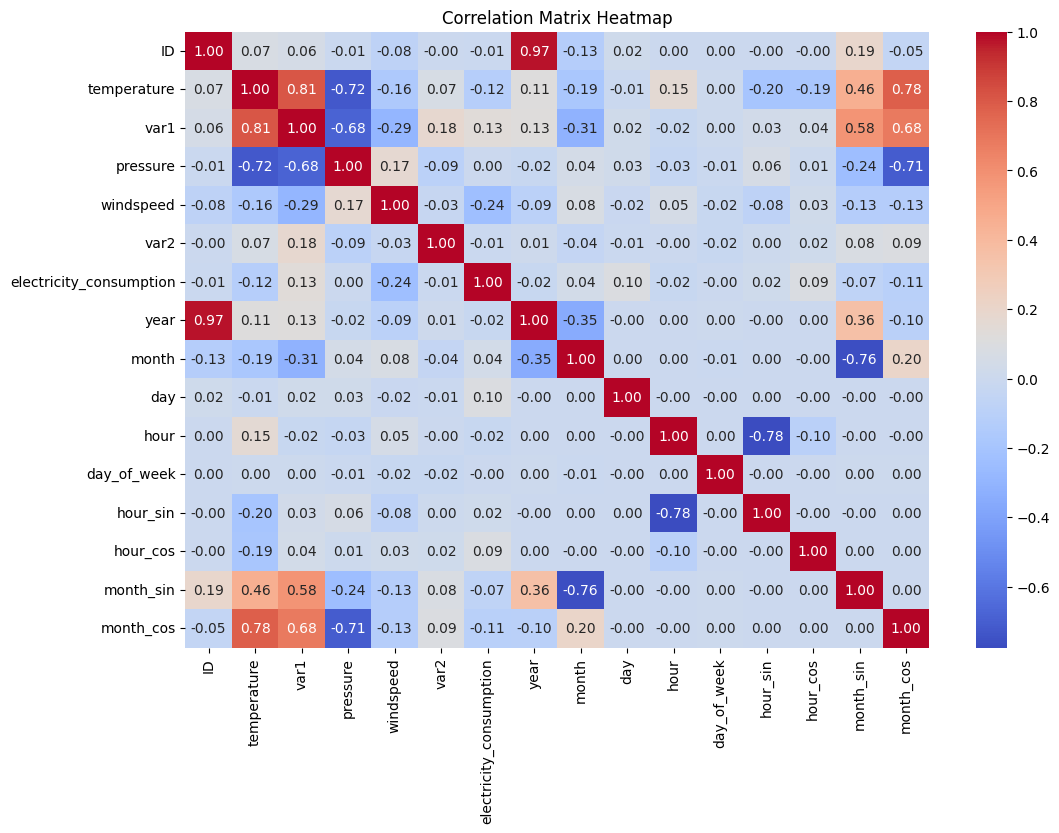

Correlation with target variable (electricity_consumption):
 ID            -0.009491
temperature   -0.117254
var1           0.133914
pressure       0.000907
windspeed     -0.238883
var2          -0.006953
year          -0.019869
month          0.040761
day            0.097964
hour          -0.021404
day_of_week   -0.000360
hour_sin       0.020938
hour_cos       0.088849
month_sin     -0.074927
month_cos     -0.107403
Name: electricity_consumption, dtype: float64
Features to drop due to high correlation: {'temperature', 'year', 'var1', 'ID'}


In [ ]:
correlation_matrix = df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


target = 'electricity_consumption'
correlation_with_target = correlation_matrix[target].drop(target)  # Exclude self-correlation
print("Correlation with target variable (electricity_consumption):\n", correlation_with_target)

threshold = 0.8

high_correlation = correlation_matrix.abs() > threshold

np.fill_diagonal(high_correlation.values, False)

features_to_drop = set()
for col in high_correlation.columns:
    if col != target and any(high_correlation[col]):
        correlated_features = high_correlation.index[high_correlation[col]].tolist()
        correlated_with_target = [f for f in correlated_features if f != target]
        if correlated_with_target:
            features_to_drop.update(correlated_with_target)

print("Features to drop due to high correlation:", features_to_drop)

In [ ]:
df.drop('temperature', axis=1, inplace=True)

In [ ]:
df.drop('ID', axis=1, inplace=True)

In [ ]:
df.year.unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'year' column
df['year'] = label_encoder.fit_transform(df['year'])

# Check the unique encoded values
print(df['year'].unique())


[0 1 2 3 4]


In [ ]:
from scipy.stats import zscore
numerical_features = df.select_dtypes(include=[np.number])
z_scores = numerical_features.apply(zscore)
threshold = 3
outliers = (z_scores.abs() > threshold)
print("Number of outliers per column:")
print(outliers.sum())
print("Original dataset size:", df.shape[0])
df = df[(~outliers).all(axis=1)]
print("Cleaned dataset size:" , df.shape[0])

'from scipy.stats import zscore\nnumerical_features = df.select_dtypes(include=[np.number])\nz_scores = numerical_features.apply(zscore)\nthreshold = 3\noutliers = (z_scores.abs() > threshold)\nprint("Number of outliers per column:")\nprint(outliers.sum())\nprint("Original dataset size:", df.shape[0])\ndf = df[(~outliers).all(axis=1)]\nprint("Cleaned dataset size:" , df.shape[0])'

In [ ]:
X = df.drop(columns=['electricity_consumption'])
y = df['electricity_consumption']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
svr_linear = SVR(kernel='linear')
svr_linear.fit(X_train, y_train)
y_pred_linear = svr_linear.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Linear Kernel R² Score: {r2_linear:.2f}")


Linear Kernel R² Score: 0.31
Linear Kernel Mean Squared Error: 8010.18


In [ ]:
svr_rbf = SVR(kernel='rbf', C=2.0, gamma=0.2, epsilon=0.01)
svr_rbf.fit(X_train, y_train)

y_pred_rbf = svr_rbf.predict(X_test)
r2_rbf = r2_score(y_test, y_pred_rbf)
print(f"RBF Kernel R² Score: {r2_linear:.2f}")


RBF Kernel R² Score: 0.31
RBF Kernel Mean Squared Error: 8010.18


In [ ]:
svr_poly = SVR(kernel='poly', degree=3, C=2.0, epsilon=0.01)
svr_poly.fit(X_train, y_train)

y_pred_poly = svr_poly.predict(X_test)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Kernel R² Score: {r2_poly:.2f}")


Polynomial Kernel R² Score: 0.21
Polynomial Kernel Mean Squared Error: 9135.47


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr=r2_score(y_test, y_pred_lr)
print(f"R² Score: {r2_lr:.2f}")

Mean Squared Error: 7391.57
R² Score: 0.36


In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: 0.5205388071668318
Mean Squared Error: 5528.881698113208


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)
r2_rf = r2_score(y_test, y_pred)
print(f"R² Score: {r2_rf:.2f}")

Mean Squared Error: 2543.68
R² Score: 0.78


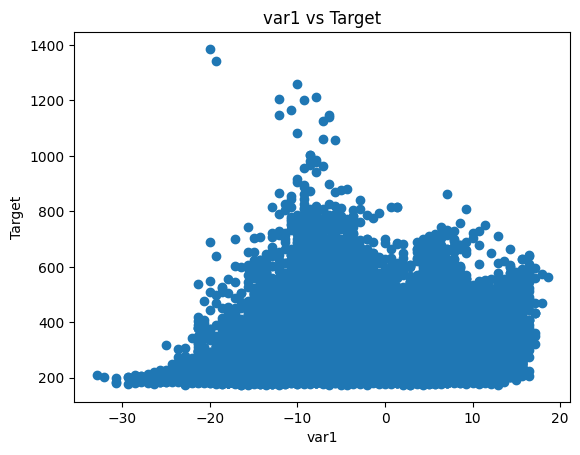

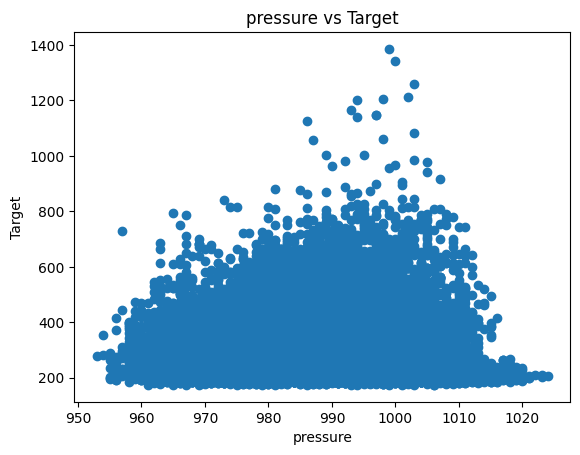

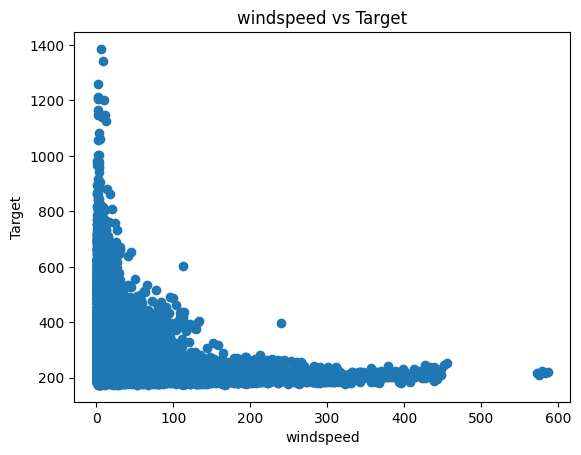

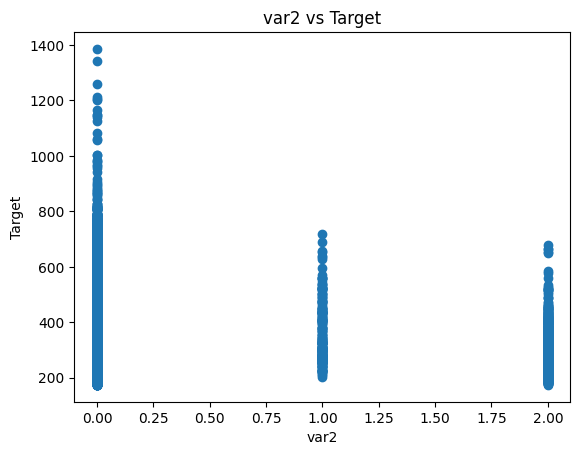

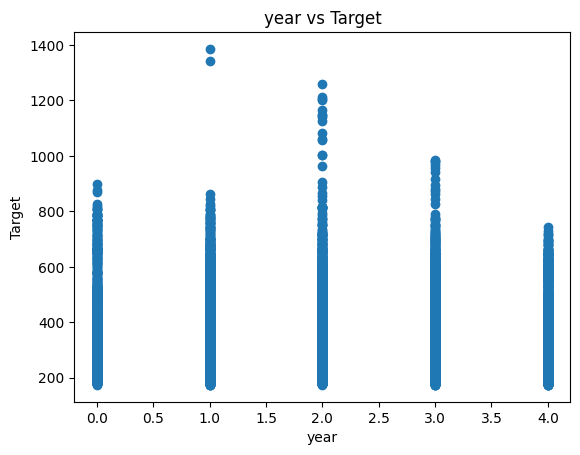

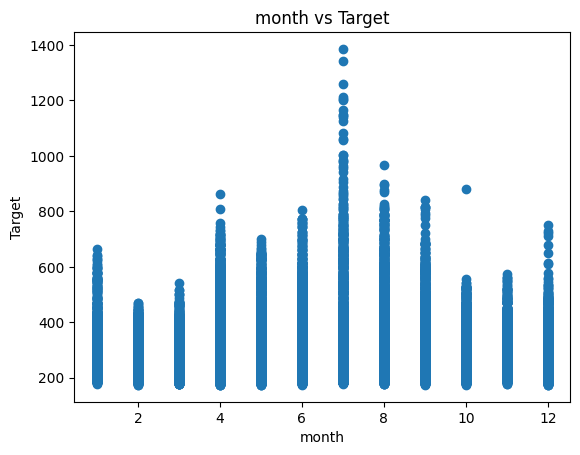

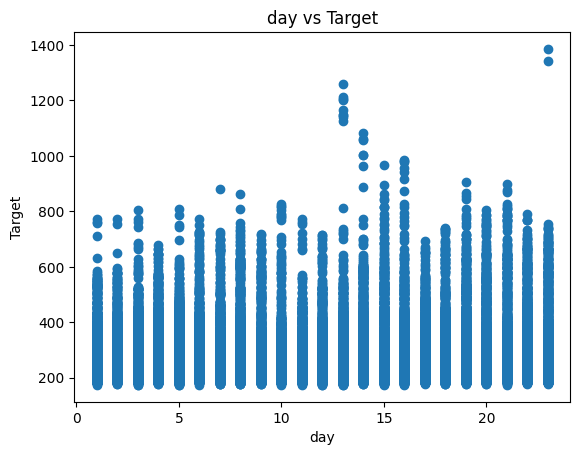

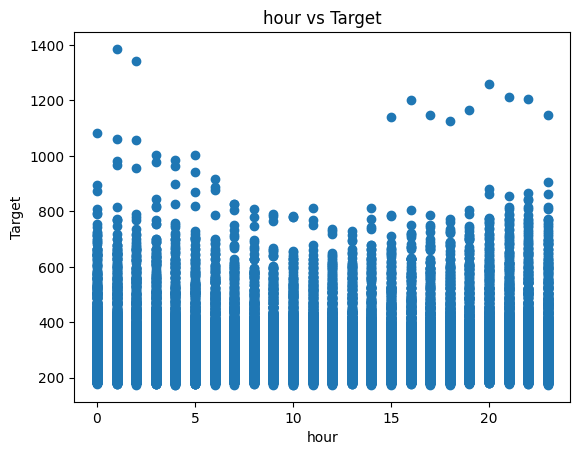

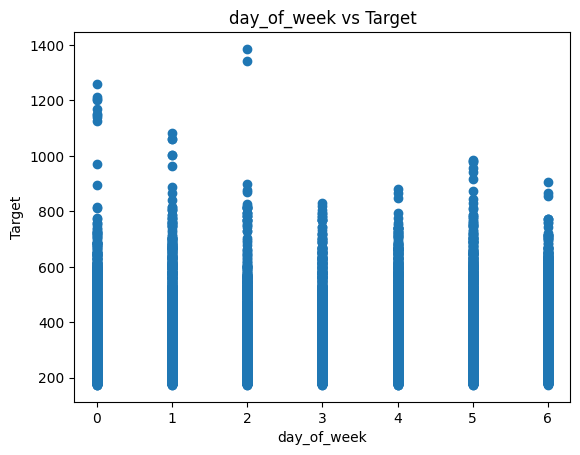

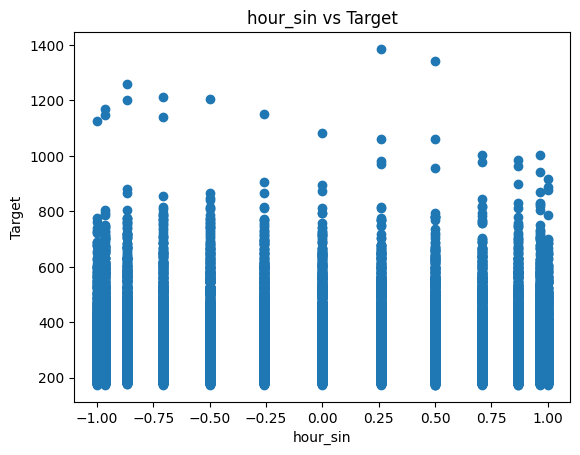

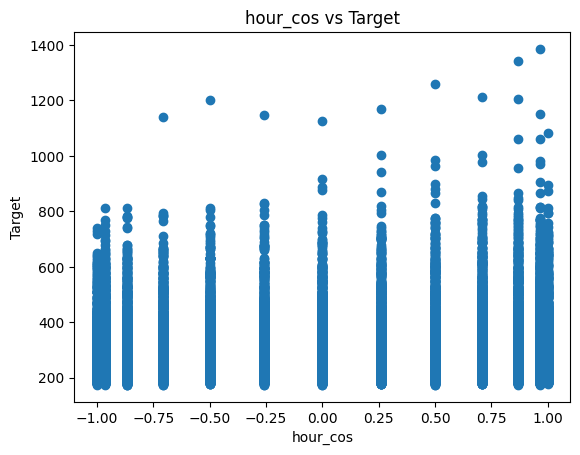

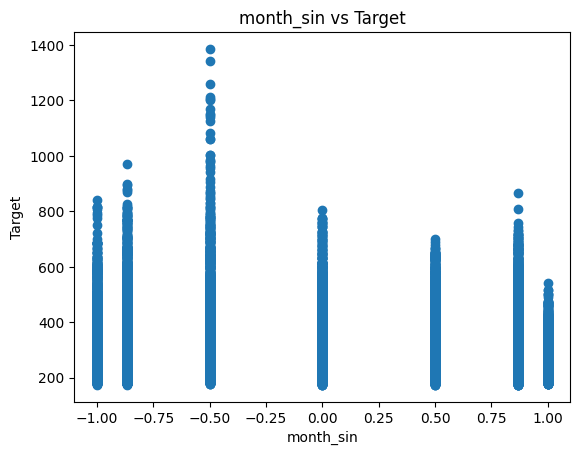

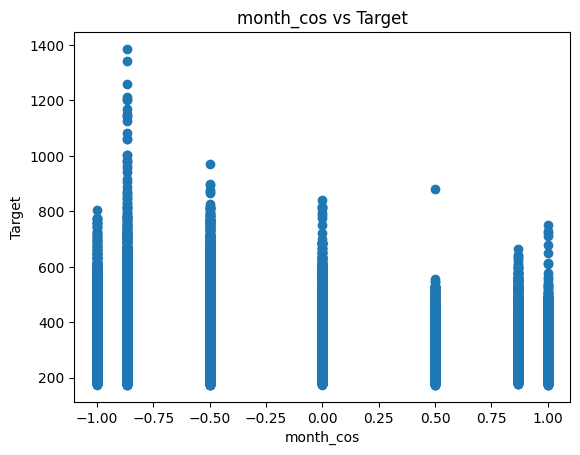

In [ ]:
for column in df.columns:
    if column != 'electricity_consumption':
        plt.scatter(df[column], df['electricity_consumption'])
        plt.title(f'{column} vs Target')
        plt.xlabel(column)
        plt.ylabel('Target')
        plt.show()
